# Minibatch training

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Initial setup

# Data

In [3]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [4]:
class Test_Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(), nn.Linear(nh,n_out)]
    
    def __call__(self):
        for l in self.layers: print(l)
        return "layers looped through"

test_model = Test_Model(m,nh,10)
test_res = test_model()
test_res

Linear(in_features=784, out_features=50, bias=True)
ReLU()
Linear(in_features=50, out_features=10, bias=True)


'layers looped through'

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross entropy loss

In practice, we will need the log of the softmax when we calculate the loss.

In [7]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [8]:
log_softmax(pred)

tensor([[-2.13, -2.29, -2.27,  ..., -2.18, -2.38, -2.36],
        [-2.11, -2.37, -2.36,  ..., -2.10, -2.38, -2.29],
        [-2.31, -2.37, -2.24,  ..., -2.08, -2.35, -2.32],
        ...,
        [-2.14, -2.52, -2.24,  ..., -2.21, -2.40, -2.36],
        [-2.23, -2.33, -2.35,  ..., -2.19, -2.26, -2.33],
        [-2.19, -2.39, -2.26,  ..., -2.21, -2.38, -2.33]], grad_fn=<LogBackward0>)

In [9]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [10]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [11]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [12]:
test_close(logsumexp(pred), pred.logsumexp(-1))

In [13]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.13, -2.29, -2.27,  ..., -2.18, -2.38, -2.36],
        [-2.11, -2.37, -2.36,  ..., -2.10, -2.38, -2.29],
        [-2.31, -2.37, -2.24,  ..., -2.08, -2.35, -2.32],
        ...,
        [-2.14, -2.52, -2.24,  ..., -2.21, -2.40, -2.36],
        [-2.23, -2.33, -2.35,  ..., -2.19, -2.26, -2.33],
        [-2.19, -2.39, -2.26,  ..., -2.21, -2.38, -2.33]], grad_fn=<SubBackward0>)

In [14]:
y_train[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.25, grad_fn=<SelectBackward0>),
 tensor(-2.11, grad_fn=<SelectBackward0>),
 tensor(-2.45, grad_fn=<SelectBackward0>))

In [16]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.25, -2.11, -2.45], grad_fn=<IndexBackward0>)

In [17]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [18]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [19]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, **`F.cross_entropy`**.

In [20]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:

- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit bette

In [21]:
loss_func = F.cross_entropy

In [22]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions

In [23]:
preds[0], preds.shape

(tensor([ 0.20,  0.04,  0.06, -0.06, -0.05,  0.08, -0.10,  0.15, -0.05, -0.03], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [24]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [25]:
loss_func(preds, yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [26]:
preds[:5]

tensor([[ 0.20,  0.04,  0.06, -0.06, -0.05,  0.08, -0.10,  0.15, -0.05, -0.03],
        [ 0.19, -0.08, -0.07, -0.14, -0.18,  0.10, -0.10,  0.20, -0.08,  0.01],
        [ 0.01, -0.05,  0.08, -0.09, -0.13,  0.11, -0.04,  0.24, -0.03, -0.00],
        [ 0.05, -0.03, -0.02, -0.14, -0.13,  0.11, -0.14,  0.14,  0.02,  0.03],
        [ 0.09,  0.05, -0.01, -0.09, -0.14,  0.21, -0.15,  0.10, -0.02,  0.03]], grad_fn=<SliceBackward0>)

In [27]:
preds.argmax(dim=1)

tensor([0, 7, 7, 7, 5, 7, 0, 7, 5, 7, 0, 7, 7, 5, 7, 7, 0, 0, 7, 7, 7, 7, 7, 7, 0, 7, 5, 7, 5, 7, 7, 7, 5, 7, 7, 7, 0, 7, 0, 5, 5, 0, 5, 5,
        0, 5, 0, 5, 7, 7])

In [28]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [29]:
# accuracy with untrained predictions #
accuracy(preds, yb)

tensor(0.06)

In [30]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [31]:
def report(loss, preds, yb): print(f"Loss: {loss:.2f}, Accuracy: {accuracy(preds, yb):.2f}") 

In [32]:
report(loss_func(preds,yb), preds, yb)

Loss: 2.31, Accuracy: 0.06


In [33]:
xb,yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds,yb), preds, yb)

Loss: 2.31, Accuracy: 0.06


**Epoch = 0**

for i = 0

In [34]:
i =0
n,bs, i

(50000, 50, 0)

In [35]:
# slice??

In [36]:
min(n,bs)

50

In [37]:
min(n,i+bs)

50

In [38]:
slice(i, min(n,i+bs))

slice(0, 50, None)

In [39]:
s = slice(i, min(n,i+bs))
s

slice(0, 50, None)

In [40]:
x_train[s].shape, y_train[s].shape

(torch.Size([50, 784]), torch.Size([50]))

In [41]:
xb,yb = x_train[s], y_train[s]
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [42]:
preds = model(xb)
preds.shape

torch.Size([50, 10])

In [43]:
loss = loss_func(preds, yb)
loss.backward()

In [44]:
hasattr

<function hasattr(obj, name, /)>

In [45]:
# hasattr??

**Signature:** hasattr(obj, name, /)

**Docstring:**
Return whether the object has an attribute with the given name.

This is done by calling getattr(obj, name) and catching AttributeError.

**Type:**      builtin_function_or_method

In [46]:
with torch.no_grad():
    for l in model.layers:
        if hasattr(l, "weight"):
            l.weight -= l.weight.grad * lr
            l.bias -= l.bias.grad * lr
            l.weight.grad.zero_()
            l.bias.grad.zero_()
    
    report(loss, preds, yb)

Loss: 2.31, Accuracy: 0.06


**full training loop**

In [47]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

Loss: 0.16, Accuracy: 0.94
Loss: 0.17, Accuracy: 0.90
Loss: 0.12, Accuracy: 0.96


## Using parameters and optim

### Parameters

In [48]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [49]:
m1.named_children()

<generator object Module.named_children at 0x000000E506504EB0>

In [50]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [51]:
m1.parameters()

<generator object Module.parameters at 0x000000E506D5F4A0>

In [52]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.15,  0.15, -0.24],
         [ 0.16, -0.04,  0.30],
         [-0.05,  0.50, -0.26],
         [-0.40, -0.52,  0.38]], requires_grad=True),
 Parameter containing:
 tensor([ 0.35,  0.43, -0.28,  0.16], requires_grad=True)]

In [53]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self,x): return self.l2(self.relu(self.l1(x)))

In [54]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [55]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [56]:
list(model.l1.parameters())

[Parameter containing:
 tensor([[    -0.01,     -0.01,     -0.00,  ...,      0.02,      0.02,     -0.02],
         [    -0.02,     -0.00,      0.01,  ...,      0.02,      0.02,     -0.02],
         [     0.03,      0.00,     -0.00,  ...,      0.02,     -0.02,     -0.00],
         ...,
         [     0.02,     -0.00,     -0.03,  ...,      0.01,      0.03,      0.02],
         [     0.00,      0.02,      0.03,  ...,     -0.00,     -0.03,     -0.02],
         [     0.01,      0.02,     -0.01,  ...,     -0.02,      0.02,      0.02]], requires_grad=True),
 Parameter containing:
 tensor([    -0.01,      0.02,      0.00,     -0.02,      0.03,     -0.02,      0.03,     -0.00,     -0.01,     -0.02,     -0.03,     -0.02,
              0.01,      0.00,      0.03,      0.01,     -0.01,     -0.02,     -0.01,     -0.02,     -0.03,     -0.02,      0.01,      0.01,
              0.02,      0.02,     -0.02,      0.03,      0.01,      0.03,     -0.02,     -0.02,      0.00,      0.01,     -0.00,     -0.0

In [57]:
list(model.named_children())

[('l1', Linear(in_features=784, out_features=50, bias=True)),
 ('l2', Linear(in_features=50, out_features=10, bias=True)),
 ('relu', ReLU())]

In [58]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [59]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [60]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds,yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
            
        report(loss, preds, yb)

In [61]:
fit()

Loss: 0.09, Accuracy: 0.96
Loss: 0.06, Accuracy: 0.98
Loss: 0.06, Accuracy: 1.00


In [62]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [63]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [64]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering modules

In [65]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [66]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [67]:
nn.Module.add_module

<function torch.nn.modules.module.Module.add_module(self, name: str, module: Union[ForwardRef('Module'), NoneType]) -> None>

In [68]:
# nn.Module.add_module??

In [69]:
reduce

<function _functools.reduce>

In [70]:
# reduce??

In [71]:
lambda x,y: x+y

<function __main__.<lambda>(x, y)>

((((1+2)+3)+4)+5)

In [72]:
reduce(lambda x, y: x+y, [1, 2, 3, 4, 5])

15

In [73]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f"layer_{i}", l)
    
    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [74]:
layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [75]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [76]:
model(xb).shape

torch.Size([50, 10])

## nn.ModelList

`nn.ModelList` does this for us.

In [77]:
nn.ModuleList

torch.nn.modules.container.ModuleList

In [78]:
nn.ModuleList??

In [79]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [80]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [81]:
fit()

Loss: 0.16, Accuracy: 0.94
Loss: 0.14, Accuracy: 0.94
Loss: 0.09, Accuracy: 0.94


## nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [82]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [83]:
fit()

Loss: 0.18, Accuracy: 0.94
Loss: 0.13, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.94


In [84]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

## optim

In [85]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr=list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [86]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))

In [87]:
opt = Optimizer(model.parameters())

In [88]:
opt.lr

0.5

In [89]:
opt.step

<bound method Optimizer.step of <__main__.Optimizer object at 0x000000E506D65730>>

In [90]:
opt.zero_grad

<bound method Optimizer.zero_grad of <__main__.Optimizer object at 0x000000E506D65730>>

In [91]:
for epoch in range(epochs):
    for i in range(0,n,bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        
        loss = loss_func(preds,yb)
        loss.backward()
        
        opt.step()
        opt.zero_grad()
    
    report(loss, preds, yb)        

Loss: 0.12, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.98
Loss: 0.07, Accuracy: 0.98


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [92]:
from torch import optim

In [93]:
optim.SGD??

In [94]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [95]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [96]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

Loss: 0.17, Accuracy: 0.96
Loss: 0.11, Accuracy: 0.94
Loss: 0.09, Accuracy: 0.96


## Dataset and DataLoader
### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
xb = x_train[s]
    yb = y_train[s]
```
Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
xb,yb = train_ds[s]
```

In [97]:
len(x_train), x_train.__len__()

(50000, 50000)

In [98]:
x_train[0].shape, x_train.__getitem__(0).shape

(torch.Size([784]), torch.Size([784]))

In [99]:
class Dataset():
    def __init__(self, x,y): self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [100]:
ds_test = Dataset(x_train, y_train)

In [101]:
len(ds_test)

50000

In [102]:
# shape of first image, the actual first image #
ds_test[0][0].shape, ds_test[0][1]

(torch.Size([784]), tensor(5))

In [103]:
(ds_test[0][0]).reshape(28,28).shape

torch.Size([28, 28])

tensor(5)


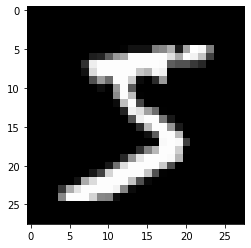

In [104]:
plt.imshow((ds_test[0][0]).reshape(28,28)); print(ds_test[0][1])

Dataset works as designed

In [105]:
aa=tensor([1.,2,3])
bb=tensor([4.,5,6])
cc=tensor([7.,8])

assert len(aa) == len(bb)

In [106]:
# assert len(aa) == len(cc)

```python
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-106-3f208d0b8a8d> in <module>
----> 1 assert len(aa) == len(cc)

AssertionError: 
```

In [107]:
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [108]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb.shape, yb.shape

(torch.Size([5, 784]), torch.Size([5]))

In [109]:
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [110]:
model, opt = get_model()

In [111]:
for epoch in range(epochs):
    for i in range(0,n, bs): # bach allocation
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

Loss: 0.11, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.98
Loss: 0.06, Accuracy: 1.00


## DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

```python
for xb,yb in train_dl
```

`__iter__(self)` is the same as `iter()`

In [112]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [113]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs)

In [114]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [115]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

In [116]:
xb[0].shape

torch.Size([784])

tensor(3)

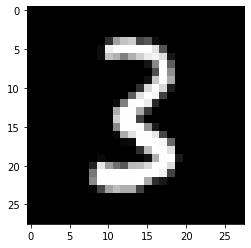

In [117]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [118]:
model,opt = get_model()

In [119]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [120]:
fit()

Loss: 0.15, Accuracy: 0.94
Loss: 0.10, Accuracy: 0.96
Loss: 0.05, Accuracy: 1.00


In [121]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

# Random sampling
We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [122]:
import random

In [123]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [124]:
from itertools import islice

In [125]:
# islice??

In [126]:
ss = Sampler(train_ds)

In [127]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [128]:
islice(ss, 5)

In [129]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [130]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss,5))

[30103, 25782, 4289, 23833, 10922]

In [131]:
import fastcore.all as fc

In [132]:
fc.store_attr

<function fastcore.basics.store_attr(names=None, self=None, but='', cast=False, store_args=None, **attrs)>

In [133]:
# fc.store_attr??

In [134]:
fc.chunked

<function fastcore.basics.chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)>

In [135]:
list(fc.chunked(iter(ss), 5))[:10]

[[1201, 49432, 6504, 10817, 2879],
 [47896, 24735, 23051, 19743, 34334],
 [47368, 36793, 13438, 21333, 27453],
 [47326, 44002, 14287, 49104, 26166],
 [23921, 41092, 34572, 6697, 40226],
 [37059, 33136, 41172, 45124, 25168],
 [46333, 40523, 22128, 5908, 37490],
 [44182, 33466, 38412, 37346, 11170],
 [34226, 7356, 29353, 10585, 31382],
 [20619, 7053, 34331, 9486, 36155]]

In [136]:
list(fc.chunked(iter(ss), chunk_sz=5))[:10]

[[24034, 264, 26958, 31607, 2784],
 [13313, 14946, 12292, 12786, 2749],
 [8668, 32018, 40726, 25639, 28029],
 [49705, 20219, 27592, 38009, 49835],
 [41461, 40439, 13189, 34549, 34982],
 [391, 6788, 31722, 49211, 39081],
 [12767, 41391, 40673, 19965, 18925],
 [35488, 49648, 46769, 33042, 5401],
 [5921, 49575, 15999, 42523, 20406],
 [16017, 40828, 21859, 43334, 6150]]

In [137]:
list(fc.chunked(iter(ss), chunk_sz=5, drop_last=False))[:5]

[[43130, 1131, 41335, 14169, 35974],
 [48861, 18174, 15781, 43632, 48169],
 [38246, 36235, 32232, 7459, 28157],
 [45606, 24917, 9354, 35443, 26408],
 [31591, 11941, 42894, 1475, 45779]]

In [138]:
list(fc.chunked(iter(ss), chunk_sz=5, drop_last=True))[:5]

[[38332, 27997, 48034, 30683, 1890],
 [33014, 31490, 5875, 40707, 39803],
 [22117, 45223, 5054, 24747, 32780],
 [1989, 33252, 17529, 11360, 24689],
 [31528, 23627, 34649, 33617, 15088]]

fc.chunked works similar to islice

In [139]:
list(islice(fc.chunked(iter(ss), chunk_sz=5, drop_last=True), 5))

[[2278, 3412, 36737, 39100, 41750],
 [9944, 1259, 32640, 15723, 31089],
 [3564, 19417, 42717, 7695, 38917],
 [48822, 33830, 9324, 17902, 48259],
 [33778, 47419, 42219, 22915, 1841]]

In [140]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [141]:
batches = BatchSampler(ss, 4)
list(islice(batches,5))

[[11367, 45422, 39182, 42807],
 [48018, 1300, 3490, 9166],
 [41319, 33100, 2964, 45310],
 [36337, 15070, 23243, 42165],
 [31320, 9024, 15470, 30586]]

In [142]:
len(valid_ds)

10000

In [143]:
xss,yss = zip(*valid_ds)

In [144]:
len(xss), len(yss)

(10000, 10000)

In [145]:
xss_stacked = torch.stack(xss)
yss_stacked = torch.stack(yss)

In [146]:
xss_stacked.shape, yss_stacked.shape

(torch.Size([10000, 784]), torch.Size([10000]))

In [147]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [148]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [149]:
# BatchSampler??

In [150]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [151]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

In [152]:
xb,yb = next(iter(valid_dl))
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

tensor(3)

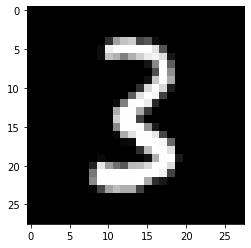

In [153]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [154]:
model,opt = get_model()

fit()

Loss: 0.10, Accuracy: 0.96
Loss: 0.17, Accuracy: 0.94
Loss: 0.06, Accuracy: 0.98


## Multiprocessing DataLoader

In [155]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [156]:
train_ds

In [157]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [158]:
train_ds[[3,6,8,1]][0].shape

torch.Size([4, 784])

In [159]:
train_ds[[3,6,8,1]][1].shape

torch.Size([4])

In [160]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [161]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


Previous DataLoader
```python
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)
```

In [162]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [163]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [164]:
# # run on gpu #
# xb,yb = next(it)
# xb.shape,yb.shape

## PyTorch DataLoader

In [165]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [168]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [169]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [170]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

Loss: 0.10, Accuracy: 0.98
Loss: 0.05, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.98


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [171]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [ ]:
# train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
# valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [174]:
# number of workers can be increased if you have more cores of proccessing power #
train_dl = DataLoader(train_ds, bs, shuffle=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [175]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

Loss: 0.18, Accuracy: 0.94
Loss: 0.05, Accuracy: 0.98
Loss: 0.09, Accuracy: 0.94


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [176]:
train_ds[[4,6,7]] 

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [177]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [178]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [180]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [181]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [182]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [184]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.15020763829350472 0.9534000039100647
1 0.11876318838447332 0.9636000031232834
2 0.1345527926646173 0.9609000080823898
3 0.11223742831498384 0.9661000061035157
4 0.11623825556598603 0.9669000059366226
Wall time: 13.8 s


In [185]:
loss, acc

(0.11623825556598603, 0.9669000059366226)